# Simple Example comparing Different Optimizers

The previous section has made many comments about the advantages and disadvantages of different optimization methods. Below we'll show with a practical example how much differences these properties actually make.


## Problem formulation

We'll consider a very simple setup to clearly illustrate what's happening: we have a two-dimensional input space $\mathbf{x}$, a mock "physical model" likewise with two dimensions $\mathbf{y}$, and a scalar loss $L$, i.e. 
$\mathbf{x} \in \mathbb{R}^2$, 
$\mathbf{y}:  \mathbb{R}^2 \rightarrow  \mathbb{R}^2 $, and 
$L:  \mathbb{R}^2 \rightarrow  \mathbb{R} $.
The components of a vector like $\mathbf{x}$ are denoted with $x_i$, and to be in sync with python arrays the indices start at 0.

Specifically, we'll use the following  $\mathbf{y}$ and $L$:

$\quad \mathbf{y}(\mathbf{x}) = \mathbf{y}(x_0,x_1) = \begin{bmatrix} x_0 \\ x_1^2 \end{bmatrix}$, 
i.e. $\mathbf{y}$ only squares the second component of its input, and

$\quad L(\mathbf{y}) = |\mathbf{y}|^2 = y_0^2 + y_1^2  \  $ 
represents a simple squared $L^2$ loss.

As starting point for some example optimizations we'll use 
$\mathbf{x} = \begin{bmatrix} 
  3 \\ 3
\end{bmatrix}$ as initial guess for solving the following simple minimization problem:

$\quad \text{arg min}_{\mathbf{x}} \ L(\mathbf{x}).$

For us as humans it's quite obvious that $[0 \ 0]^T$ is the right answer, but let's see how quickly the different optimization algorithms discussed in the previous section can find that solution. And while $\mathbf{y}$ is a very simple function, it is nonlinear due to its $x_1^2$.





## 3 Spaces

In order to understand the following examples, it's important to keep in mind that we're dealing with mappings between the three _spaces_ we've introduced here:
$\mathbf{x}$, $\mathbf{y}$ and $L$. A regular forward pass maps an
$\mathbf{x}$ via $\mathbf{y}$ to $L$, while for the optimization we'll need to associate values
and changes in $L$ with positions in $\mathbf{x}$. While doing this, it will 
be interesting how this influences the positions in $\mathbf{y}$ that develop while searching for
the right position in $\mathbf{x}$.

```{figure} resources/placeholder.png
---
height: 220px
name: pg-three-spaces
---
TODO, visual overview of 3 spaces
```



## Implementation

For this example we'll use the [JAX framework](https://github.com/google/jax), which represents a nice alternative to pytorch and tensorflow for efficiently working with differentiable functions.
JAX also has a nice numpy wrapper that implements most of numpy's functions. Below we'll use this wrapper as `np`, and the _original_ numpy as `onp`.



In [1]:
import jax
import jax.numpy as np
import numpy as onp


We'll start by defining the $\mathbf{y}$ and $L$ functions, together with a single composite function `fun` which calls L and y. Having a single native python function is necessary for many of the JAX operations.

In [2]:
# "physics" function y
def fun_y(x):
    return np.array( [x[0], x[1]*x[1]] )

# simple L2 loss
def fun_L(y):
    #return y[0]*y[0] + y[1]*y[1] # "manual version"
    return np.sum( np.square(y) )

# composite function with L & y
def fun(x):
    return fun_L(fun_y(x))


x = np.asarray([3,3], dtype=np.float32)
print("Starting point x = "+format(x) +"\n")

print("Some test calls of the functions we defined so far, from top to bottom, y, manual L(y), L(y):") 
fun_y(x) , fun_L( fun_y(x) ), fun(x) 

Starting point x = [3. 3.]

Some test calls of the functions we defined so far, from top to bottom, y, manual L(y), L(y):


(DeviceArray([3., 9.], dtype=float32),
 DeviceArray(90., dtype=float32),
 DeviceArray(90., dtype=float32))

Now we can evaluate the derivatives of our function via `jax.grad`. E.g., `jax.grad(fun_L)(fun_y(x))` evaluates the Jacobian $\partial L / \partial \mathbf{y}$. The cell below evaluates this and a few variants, together with a sanity check for the inverse of the Jacobian of $\mathbf{y}$:

In [3]:
# this works:
print("Jacobian L(y): " + format(jax.grad(fun_L)(fun_y(x))) +"\n")

# the following would give an error as y (and hence fun_y) is not scalar
#jax.grad(fun_y)(x) 

# computing the jacobian of y is a valid operation:
J = jax.jacobian(fun_y)(x)
print( "Jacobian y(x): \n" + format(J) ) 

# the code below also gives error, JAX grad needs a single function object
#jax.grad( fun_L(fun_y) )(x) 

print( "\nSanity check with inverse Jacobian of y, this should give x again: " + format(np.linalg.solve(J, np.matmul(J,x) )) +"\n")

# instead use composite 'fun' from above
print("Gradient for full L(x): " + format( jax.grad(fun)(x) )  +"\n")


Jacobian L(y): [ 6. 18.]

Jacobian y(x): 
[[1. 0.]
 [0. 6.]]

Sanity check with inverse Jacobian of y, this should give x again: [3. 3.]

Gradient for full L(x): [  6. 108.]



The last line is worth a closer look: here we print the gradient $\partial L / \partial \mathbf{x}$ at our initial position. And while we know that we should just move diagonally towards the origin (with the zero vector being the minimizer), this gradient is not very diagonal - it has a strongly dominant component along $x_1$ with an entry of 108.

Let's see how the different methods cope with this situation. We'll compare 

* the first order method _gradient descent_ (i.e., regular, non-stochastic, "steepest gradient descent"), 

* _Newton's method_ as a representative of the second order methods, 

* and scale-invariant updates from _inverse simulators_.


## Gradient descent

For gradient descent, the simple gradient based update from equation {eq}`GD-update`
in our setting gives the following update step in $\mathbf{x}$:

$$\begin{aligned}
\Delta \mathbf{x} 
&= 
- \eta ( J_{L} J_{\mathbf{y}} )^T  \\
&=
- \eta \big( \frac{\partial L }{ \partial \mathbf{y} } \frac{\partial \mathbf{y} }{ \partial \mathbf{x} }  \big)^T
\end{aligned}$$

where $\eta$ denotes the step size parameter .

Let's start the optimization via gradient descent at $x=[3,3]$, and update our solution ten times with
$\eta = 0.01$:


In [4]:
x = np.asarray([3.,3.])
eta = 0.01
historyGD = [x]; updatesGD = []

for i in range(10):
    G = jax.grad(fun)(x)
    x += -eta * G
    historyGD.append(x); updatesGD.append(G)
    print( "GD iter %d: "%i + format(x) )


GD iter 0: [2.94      1.9200001]
GD iter 1: [2.8812    1.6368846]
GD iter 2: [2.823576  1.4614503]
GD iter 3: [2.7671044 1.3365935]
GD iter 4: [2.7117622 1.2410815]
GD iter 5: [2.657527  1.1646168]
GD iter 6: [2.6043763 1.1014326]
GD iter 7: [2.5522888 1.0479842]
GD iter 8: [2.501243  1.0019454]
GD iter 9: [2.4512184  0.96171147]


Here we've already printed the resulting positions in $\mathbf{x}$, and they seem to be going down, i.e. moving in the right direction. The last point, $[2.451 \  0.962]$ still has a fair distance of 2.63 to the origin.

Let's take a look at the progression over the course of the iterations (the evolution was stored in the `history` list above). The blue points denote the positions in $\mathbf{x}$ from the GD iterations, with the target at the origin shown with a thin black cross.

Text(0, 0.5, 'x1')

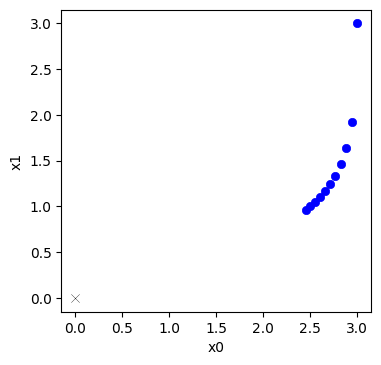

In [5]:
import matplotlib.pyplot as plt
axes = plt.figure(figsize=(4, 4), dpi=100).gca()
historyGD = onp.asarray(historyGD)
updatesGD = onp.asarray(updatesGD) # for later
axes.scatter(historyGD[:,0], historyGD[:,1], lw=0.5, color='blue')
axes.scatter([0], [0], lw=0.25, color='black', marker='x') # target at 0,0
axes.set_xlabel('x0')
axes.set_ylabel('x1')

No surprise here: the initial step mostly moves downwards along $x_1$ (in top right corner), and the updates afterwards curve towards the origin. But they don't get very far. It's still quite a distance to the solution in the bottom left corner.

## Newton

For Newton's method, the update step is given by

$$
\begin{aligned}
\Delta \mathbf{x} &= 
- \eta \left( \frac{\partial^2 L }{ \partial \mathbf{x}^2 }  \right)^{-1}
  \frac{\partial L }{ \partial \mathbf{x} }
\\
&=
- \eta \ H_L^{-1} \ ( J_{L} J_{\mathbf{y}} )^T
\end{aligned}
$$

Hence, in addition to the same gradient as for GD, we now need to evaluate and invert the Hessian of $\frac{\partial^2 L }{ \partial \mathbf{x}^2 }$.

This is quite straightforward in JAX: we can call `jax.jacobian` two times, and then use the JAX version of `linalg.inv` to invert the resulting matrix.

For the optimization with Newton's method we'll use a larger step size of $\eta =1/3$. For this example and the following one, we've chosen the step size such that the magnitude of the first update step is roughly the same as the one of GD. In this way, we can compare the trajectories of all three methods relative to each other. Note that this is by no means meant to illustrate or compare the stability of the methods here. Stability and upper limits for $\eta$  are separate topics. Here we're focusing on convergence properties.

In the next cell, we apply the Newton updates ten times starting from the same initial guess:

In [6]:
x = np.asarray([3.,3.])
eta = 1./3.
historyNt = [x]; updatesNt = []

for i in range(10):
    G = jax.grad(fun)(x)
    H = jax.jacobian(jax.jacobian(fun))(x)
    #H = jax.jacfwd(jax.jacrev(fun_Ly))(x) # alternative
    Hinv = np.linalg.inv(H)
    
    x += -eta * np.matmul( Hinv , G)
    historyNt.append(x); updatesNt.append( np.matmul( Hinv , G) )
    print( "Newton iter %d: "%i + format(x) )



Newton iter 0: [2.        2.6666667]
Newton iter 1: [1.3333333 2.3703704]
Newton iter 2: [0.88888884 2.1069958 ]
Newton iter 3: [0.59259254 1.8728852 ]
Newton iter 4: [0.39506167 1.6647868 ]
Newton iter 5: [0.26337445 1.4798105 ]
Newton iter 6: [0.17558296 1.315387  ]
Newton iter 7: [0.1170553 1.1692328]
Newton iter 8: [0.07803687 1.0393181 ]
Newton iter 9: [0.05202458 0.92383826]


The last line already indicates: Newton's method does quite a bit better. The last point $[0.052 \ 0.924]$ only has a distance of 0.925 to the origin (compared to 2.63 for GD)

Below, we plot the Newton trajectory in orange next to the GD version in blue.

Text(0, 0.5, 'x1')

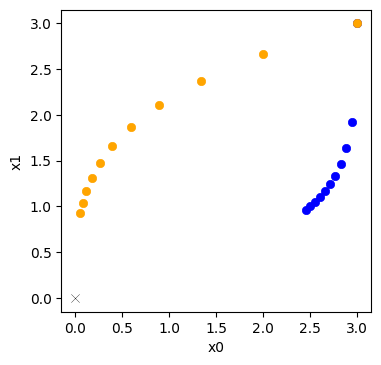

In [7]:
axes = plt.figure(figsize=(4, 4), dpi=100).gca()
historyNt = onp.asarray(historyNt)
updatesNt = onp.asarray(updatesNt) 
axes.scatter(historyGD[:,0], historyGD[:,1], lw=0.5, color='blue')
axes.scatter(historyNt[:,0], historyNt[:,1], lw=0.5, color='orange')
axes.scatter([0], [0], lw=0.25, color='black', marker='x') # target at 0,0
axes.set_xlabel('x0')
axes.set_ylabel('x1')

Not completely surprising: for this simple example we can reliably evaluate the Hessian, and Newtons's method profits from the second order information. It's trajectory is much more diagonal (that would be the ideal, shortest path to the solution), and does not slow down as much as GD.

## Inverse simulators

Now we also use an analytical inverse of y for the optimization:
$\mathbf{y}^{-1}(\mathbf{x}) = [x_0 \ x_1^{1/2}]^T$, to compute the scale-invariant update denoted by PG below. As a slight look-ahead to the next section, we'll use a Newton's step for $L$, and combine it with the inverse physics function to get an overall update. This gives an update step:

$$\begin{aligned}
\Delta \mathbf{x} &= 
\mathbf{y}^{-1} \left( \mathbf{y}(\mathbf{x}) - \eta
  \left( \frac{\partial^2 L }{ \partial \mathbf{y}^2 }  \right)^{-1}
  \frac{\partial L }{ \partial \mathbf{y} }
\right) - \mathbf{x}
\end{aligned}$$

Below, we define our inverse function `fun_y_inv_analytic` (we'll come to a variant below), and then evaluate an optimization with the PG update for ten steps:


In [8]:
x = np.asarray([3.,3.])
eta = 0.3
historyPG = [x]; historyPGy = []; updatesPG = []

def fun_y_inv_analytic(y):
    return np.array( [y[0], np.power(y[1],0.5)] )

for i in range(10):
    
    # Newton step for L(y)
    zForw = fun_y(x)
    GL = jax.grad(fun_L)(zForw)
    HL = jax.jacobian(jax.jacobian(fun_L))(zForw)
    HLinv = np.linalg.inv(HL)
    
    # step in y space
    zBack = zForw -eta * np.matmul( HLinv , GL)
    historyPGy.append(zBack)

    # "inverse physics" step via y-inverse
    x = fun_y_inv_analytic(zBack)
    historyPG.append(x)
    updatesPG.append( historyPG[-2] - historyPG[-1] )
    print( "PG iter %d: "%i + format(x) )



PG iter 0: [2.1       2.5099802]
PG iter 1: [1.4699999 2.1000001]
PG iter 2: [1.0289999 1.7569861]
PG iter 3: [0.72029996 1.47      ]
PG iter 4: [0.50421   1.2298902]
PG iter 5: [0.352947 1.029   ]
PG iter 6: [0.24706289 0.86092323]
PG iter 7: [0.17294402 0.7203    ]
PG iter 8: [0.12106082 0.60264623]
PG iter 9: [0.08474258 0.50421   ]


Now we obtain $[0.084 \  0.504]$ as the final position, with a distance of only 0.51! This is clearly better than both Newton and GD.

Let's directly visualize how the PGs (in red) fare in comparison to Newton's method (orange) and GD (blue).

Text(0, 0.5, 'x1')

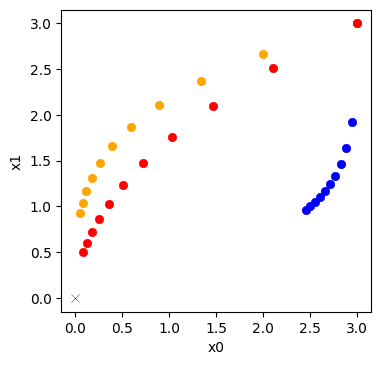

In [9]:
historyPG = onp.asarray(historyPG)
updatesPG = onp.asarray(updatesPG) 

axes = plt.figure(figsize=(4, 4), dpi=100).gca()
axes.scatter(historyGD[:,0], historyGD[:,1], lw=0.5, color='blue')
axes.scatter(historyNt[:,0], historyNt[:,1], lw=0.5, color='orange')
axes.scatter(historyPG[:,0], historyPG[:,1], lw=0.5, color='red')
axes.scatter([0], [0], lw=0.25, color='black', marker='x') # target at 0,0
axes.set_xlabel('x0')
axes.set_ylabel('x1')

This illustrates that the PG variant does significantly better than Newton's method. It yields a trajectory that is better aligned with the _diagonal_, and its final state is closer to the origin. A key ingredient here is the inverse function for $\mathbf{y}$, which yielded higher order terms than the second-order approximation for Newton's method. Despite the simplicity of the problem, Newton's method has problems finding the right search direction. For PG, on the other hand, the higher order information yields an improved direction for the optimization.

This difference also shows in first update step for each method: below we measure how well it is aligned with the diagonal.

In [10]:
def mag(x):
    return np.sqrt(np.sum(np.square(x)))

def one_len(x):
    return np.dot( x/mag(x), np.array([1,1])) 

print("Diagonal lengths (larger is better): GD %f, Nt %f, PG %f " % 
      (one_len(updatesGD[0]) , one_len(updatesNt[0]) , one_len(updatesPG[0])) )


Diagonal lengths (larger is better): GD 1.053930, Nt 1.264911, PG 1.356443 


The largest value of 1.356 for PG confirms what we've seen above: the PG gradient was the closest one to the diagonal direction from our starting point to the origin.


---

<br>

## y Space

To understand the behavior and differences of the methods here, it's important to keep in mind that we're not dealing with a black box that maps between $\mathbf{x}$ and $L$, but rather there are spaces in between that matter. In our case, we only have a single $\mathbf{y}$ space, but for DL settings, we might have a large number of latent spaces, over which we have a certain amount of control. We will return to NNs soon, but for now let's focus on $\mathbf{y}$. 

A first thing to note is that for PG, we explicitly map from $L$ to $\mathbf{y}$, and then continue with a mapping to $\mathbf{x}$. Thus we already obtained the trajectory in $\mathbf{y}$ space, and not coincidentally, we already stored it in the `historyPGy` list above.

Let's directly take a look what PG did in $\mathbf{y}$ space:

Text(0, 0.5, 'z1')

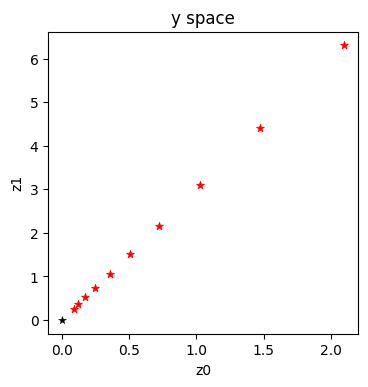

In [11]:
historyPGy = onp.asarray(historyPGy)

axes = plt.figure(figsize=(4, 4), dpi=100).gca()
axes.set_title('y space')
axes.scatter(historyPGy[:,0], historyPGy[:,1], lw=0.5, color='red', marker='*')
axes.scatter([0], [0], lw=0.25, color='black', marker='*') 
axes.set_xlabel('z0')
axes.set_ylabel('z1')

For PG we're making explicit steps in $\mathbf{y}$ space, which progress in a straight diagonal line to the origin  (which is likewise the solution in $\mathbf{y}$ space).



Interestingly, neither GD nor Newton's method give us information about progress in intermediate spaces (like the $\mathbf{y}$ space). 

For **GD** we're concatenating the Jacobians, so we're moving in directions that locally should decrease the loss. However, the $\mathbf{y}$ position is influenced by $\mathbf{x}$, and hence we don't know where we end up in $\mathbf{y}$ space until we have the definite point there. (For NNs in general we won't know at which latent-space points we end up after a GD update until we've actually computed all updated weights.)

More specifically, we have an update $-\eta \frac{\partial L}{\partial \mathbf{x}}$ for GD, which means we arrive at $\mathbf{y}(\mathbf{x} -\eta \frac{\partial L}{\partial \mathbf{x}})$ in $\mathbf{y}$ space. A Taylor expansion with 
$h = \eta \frac{\partial L}{\partial \mathbf{x}}$ yields 

$
\quad
\mathbf{y}(\mathbf{x} - h) = 
\mathbf{y}(\mathbf{x}) - h \frac{\partial \mathbf{y}}{\partial \mathbf{x}} + \mathcal{O}( h^2 )
= \mathbf{y}(x) - \eta \frac{\partial L}{\partial \mathbf{y}} (\frac{\partial \mathbf{y}}{\partial x})^2 + \mathcal{O}( h^2 )
$.

And $\frac{\partial L}{\partial \mathbf{y}} (\frac{\partial \mathbf{y}}{\partial \mathbf{x}})^2$ clearly differs from the step $\frac{\partial L}{\partial \mathbf{y}}$ we would compute during the backpropagation pass in GD for $\mathbf{y}$.

**Newton's method** does not fare much better: we compute first-order derivatives like for GD, and the second-order derivatives for the Hessian for the full process. But since both are approximations, the actual intermediate states resulting from an update step are unknown until the full chain is evaluated. In the _Consistency in function compositions_ paragraph for Newton's method in {doc}`physgrad` the squared $\frac{\partial \mathbf{y}}{\partial \mathbf{x}}$ term for the Hessian already indicated this dependency.

With **PGs** we do not have this problem: PGs can directly map points in $\mathbf{y}$ to $\mathbf{x}$ via the inverse function. Hence we know eactly where we started in $\mathbf{y}$ space, as this position is crucial for evaluating the inverse.

In the simple setting of this section, we only have a single latent space, and we already stored all values in  $\mathbf{x}$ space during the optimization (in the `history` lists). Hence, now we can go back and re-evaluate `fun_y` to obtain the positions in $\mathbf{y}$ space.

In [12]:
x = np.asarray([3.,3.])
eta = 0.01
historyGDy = []
historyNty = []

for i in range(1,10):
    historyGDy.append(fun_y(historyGD[i]))
    historyNty.append(fun_y(historyNt[i]))

historyGDy = onp.asarray(historyGDy)
historyNty = onp.asarray(historyNty)


Text(0, 0.5, 'z1')

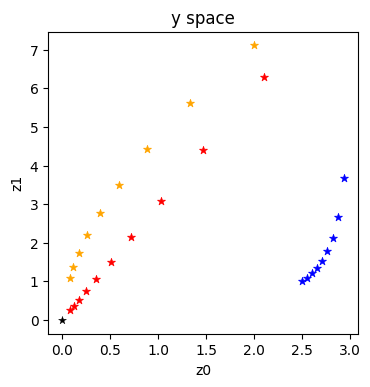

In [13]:
axes = plt.figure(figsize=(4, 4), dpi=100).gca()
axes.set_title('y space')
axes.scatter(historyGDy[:,0], historyGDy[:,1], lw=0.5, marker='*', color='blue')
axes.scatter(historyNty[:,0], historyNty[:,1], lw=0.5, marker='*', color='orange')
axes.scatter(historyPGy[:,0], historyPGy[:,1], lw=0.5, marker='*', color='red')
axes.scatter([0], [0], lw=0.25, color='black', marker='*') 
axes.set_xlabel('z0')
axes.set_ylabel('z1')

These trajectories confirm the intuition outlined in the previous sections: GD in blue gives a very sub-optimal trajectory in $\mathbf{y}$. Newton (in orange) does better, but is still clearly curved. It can't approximate the higher order terms of this example well enough. This is in contrast to the straight, and diagonal red trajectory for the optimization using the inverse simulator.

The behavior in intermediate spaces becomes especially important when they're not only abstract latent spaces as in this example, but when they have actual physical meanings.

## Conclusions 

Despite its simplicity, this simple example already shows surprisingly large differences between gradient descent, Newton's method, and using the _inverse simulator_.

The main takeaways of this section are the following.
* GD easily yields "unbalanced" updates, and gets stuck.
* Newtons method does better, but is far from optimal.
* the higher-order information of the invese simulator  outperform both, even if it is applied only partially (we still used Newton's method for $L$ above).
* Also, the choice of optimizer strongly affects progress in latent spaces like $\mathbf{y}$.
    
In the next sections we can build on these observations to use PGs for training NNs via invertible physical models.


---

## Approximate inversions

If an analytic inverse like the `fun_y_inv_analytic` above is not readily available, we can actually resort to optimization schemes like Newton's method or BFGS to obtain a local inverse numerically. This is a topic that is orthogonal to the comparison of different optimization methods, but it can be easily illustrated based on the PG example above.

Below, we'll use the BFGS variant `fmin_l_bfgs_b` from `scipy` to compute the inverse. It's not very complicated, but we'll use numpy and scipy directly here, which makes the code a bit messier than it should be.

In [14]:
def fun_y_inv_opt(target_y, x_ini):
    # a bit ugly, we switch to pure scipy here inside each iteration for BFGS
    import numpy as np
    from scipy.optimize import fmin_l_bfgs_b
    target_y = onp.array(target_y)
    x_ini    = onp.array(x_ini)

    def fun_y_opt(x,target_y=[2,2]):
        y = onp.array( [x[0], x[1]*x[1]] ) # we cant use fun_y from JAX here
        ret = onp.sum( onp.square(y-target_y) )
        return ret
    
    ret = fmin_l_bfgs_b(lambda x: fun_y_opt(x,target_y), x_ini, approx_grad=True )
    #print( ret ) # return full BFGS details
    return ret[0]

print("BFGS optimization test run, find x such that y=[2,2]:")
fun_y_inv_opt([2,2], [3,3])


BFGS optimization test run, find x such that y=[2,2]:


array([2.00000003, 1.41421353])

Nonetheless, we can now use this numerically inverted $\mathbf{y}$ function to perform the PG optimization. Apart from calling `fun_y_inv_opt`, the rest of the code is unchanged.

In [15]:
x = np.asarray([3.,3.])
eta = 0.3
history = [x]; updates = []

for i in range(10):    
    # same as before, Newton step for L(y)
    y = fun_y(x)
    GL = jax.grad(fun_L)(y)
    y += -eta * np.matmul( np.linalg.inv( jax.jacobian(jax.jacobian(fun_L))(y) ) , GL)

    # optimize for inverse physics, assuming we dont have access to an inverse for fun_y
    x = fun_y_inv_opt(y,x)
    history.append(x)
    updates.append( history[-2] - history[-1] )
    print( "PG iter %d: "%i + format(x) )


PG iter 0: [2.09999967 2.50998022]
PG iter 1: [1.46999859 2.10000011]
PG iter 2: [1.02899871 1.75698602]
PG iter 3: [0.72029824 1.4699998 ]
PG iter 4: [0.50420733 1.22988982]
PG iter 5: [0.35294448 1.02899957]
PG iter 6: [0.24705997 0.86092355]
PG iter 7: [0.17294205 0.72030026]
PG iter 8: [0.12106103 0.60264817]
PG iter 9: [0.08474171 0.50421247]


Nice! It works, just like PG. Not much point plotting this, it's basically the PG version, but let's measure the difference. Below, we compute the MAE, which for this simple example turns out to be on the order of our floating point accuracy.

In [16]:
historyPGa = onp.asarray(history)
updatesPGa = onp.asarray(updates) 

print("MAE difference between analytic PG and approximate inversion: %f" % (np.average(np.abs(historyPGa-historyPG))) )


MAE difference between analytic PG and approximate inversion: 0.000001


<br>

---

## Next steps

Based on this code example you can try the following modifications:

- Instead of the simple L(y(x)) function above, try other, more complicated functions.

- Replace the simple "regular" gradient descent with another optimizer, e.g., commonly used DL optimizers such as AdaGrad, RmsProp or Adam. Compare the versions above with the new trajectories.